In [ ]:
import os
import shutil
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# --- Dossiers source ---
# Pour Jupyter Notebook: utiliser le répertoire courant
# Le notebook est dans Heart-Disease/, donc BASE_PATH = répertoire courant
BASE_PATH = os.getcwd()
# Si le notebook est dans un sous-dossier, trouver le bon répertoire
# Chercher le répertoire qui contient "processed_dataset" ou "Dataset"
while BASE_PATH and not (os.path.exists(os.path.join(BASE_PATH, "processed_dataset")) or 
                         os.path.exists(os.path.join(BASE_PATH, "Dataset"))):
    parent = os.path.dirname(BASE_PATH)
    if parent == BASE_PATH:  # On est à la racine
        BASE_PATH = os.getcwd()  # Revenir au répertoire courant
        break
    BASE_PATH = parent

base_dir = os.path.join(BASE_PATH, "Dataset")
output_dir = os.path.join(BASE_PATH, "processed_dataset")

print(f"BASE_PATH: {BASE_PATH}")
print(f"base_dir existe: {os.path.exists(base_dir)}")
print(f"output_dir existe: {os.path.exists(output_dir)}")

normal_dir = os.path.join(base_dir, "Normal Person ECG Images")
abnormal_dirs = [
    os.path.join(base_dir, "ECG Images of Myocardial Infarction Patients"),
    os.path.join(base_dir, "ECG Images of Patient that have abnormal heartbeat"),
    os.path.join(base_dir, "ECG Images of Patient that have History of MI")
]

BASE_PATH: C:\Users\ilias\Desktop\Deep Learning\Heart-Disease\Heart-Disease
base_dir existe: True
output_dir existe: True


In [ ]:
# --- Dossiers cibles ---
normal_out = os.path.join(output_dir, "Normal")
abnormal_out = os.path.join(output_dir, "Anormal")
os.makedirs(normal_out, exist_ok=True)
os.makedirs(abnormal_out, exist_ok=True)


In [ ]:
def clear_directory(path):
    for entry in os.listdir(path):
        full_path = os.path.join(path, entry)
        if os.path.isfile(full_path) or os.path.islink(full_path):
            os.remove(full_path)
        elif os.path.isdir(full_path):
            shutil.rmtree(full_path)


clear_directory(normal_out)
clear_directory(abnormal_out)

In [ ]:
# --- Paramètres ---
target_size = (224, 224)
num_normal = 284
total_anormal = 284  # nombre total d'images anormales
blur_kernel_size = (5, 5)


In [ ]:
# Répartition équilibrée entre les 3 catégories anormales
num_anomalous_images = [round(total_anormal / 3)] * 3  # environ 95 chacune

In [ ]:
def process_and_save_images(input_paths, output_dir, limit=None):
    random.shuffle(input_paths)
    if limit:
        input_paths = input_paths[:limit]
    for path in input_paths:
        try:
            img = cv2.imread(path)
            if img is None:
                continue
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(gray, blur_kernel_size, 0)
            equalized = cv2.equalizeHist(blurred)
            resized = cv2.resize(equalized, target_size, interpolation=cv2.INTER_AREA)
            filename = os.path.basename(path)
            cv2.imwrite(os.path.join(output_dir, filename), resized)
        except Exception as e:
            print(f"Erreur sur {path}: {e}")

In [ ]:
# --- Normal ---
normal_images = [
    os.path.join(normal_dir, f) for f in os.listdir(normal_dir)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]
process_and_save_images(normal_images, normal_out, limit=num_normal)


In [ ]:
# --- Anormal (équilibré à 284 au total) ---
for subdir, limit in zip(abnormal_dirs, num_anomalous_images):
    imgs = [
        os.path.join(subdir, f) for f in os.listdir(subdir)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]
    process_and_save_images(imgs, abnormal_out, limit=limit)

In [ ]:
# --- Vérification finale ---
num_final_normal = len(os.listdir(normal_out))
num_final_anormal = len(os.listdir(abnormal_out))
print("Dataset traité et équilibré avec succès !")
print(f"Nombre d'images normales : {num_final_normal}")
print(f"Nombre d'images anormales : {num_final_anormal}")

In [ ]:
# ============================================================================
# FONCTION POUR CROPPER LES BORDURES BLANCHES ET LE TEXTE EN HAUT
# ============================================================================

def crop_white_borders(image_path, threshold=250, padding=0, remove_text_header=True, 
                       text_zone_height=0.20, min_content_density=0.05):
    """
    Crop les bordures blanches d'une image et supprime les zones de texte en haut.
    
    Parameters:
    -----------
    image_path : str
        Chemin vers l'image à traiter
    threshold : int
        Seuil de valeur de pixel pour considérer comme "blanc" (0-255)
    padding : int
        Padding à ajouter autour de l'image croppée (en pixels)
    remove_text_header : bool
        Si True, supprime les zones de texte en haut de l'image
    text_zone_height : float
        Pourcentage de l'image à analyser depuis le haut pour la détection de texte (0.0-1.0)
    min_content_density : float
        Densité minimale de contenu non-blanc pour considérer une zone comme contenant de l'ECG (0.0-1.0)
    
    Returns:
    --------
    cropped_image : numpy array
        Image croppée, ou None si erreur
    bbox : tuple
        (x, y, width, height) de la zone croppée
    """
    # Charger l'image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Erreur: Impossible de charger l'image {image_path}")
        return None, None
    
    # Convertir en niveaux de gris si nécessaire
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    height, width = gray.shape
    
    # Étape 1: Supprimer le texte et les zones blanches en haut
    y_start = 0
    if remove_text_header:
        # Analyser les lignes depuis le haut pour trouver où commence le vrai contenu ECG
        # Les ECG ont généralement des lignes horizontales régulières (grille)
        search_height = int(height * text_zone_height)
        
        # Méthode simplifiée et efficace:
        # 1. Parcourir les lignes depuis le haut
        # 2. Pour chaque ligne, calculer la densité de contenu non-blanc
        # 3. Trouver la première zone avec plusieurs lignes consécutives ayant du contenu
        #    (caractéristique des grilles ECG, contrairement au texte qui est plus dispersé)
        
        best_y = 0
        consecutive_lines_with_content = 0
        min_consecutive_lines = 8  # Nombre minimum de lignes consécutives avec contenu
        
        for y in range(0, min(search_height, height - 20)):
            # Analyser une ligne horizontale
            line = gray[y, :]
            
            # Compter les pixels non-blancs dans cette ligne
            non_white_pixels = np.sum(line < threshold)
            non_white_ratio = non_white_pixels / width
            
            # Si la ligne a suffisamment de contenu (plus que juste du bruit)
            if non_white_ratio > min_content_density:
                consecutive_lines_with_content += 1
                
                # Si on a trouvé assez de lignes consécutives, c'est probablement le début de la grille ECG
                if consecutive_lines_with_content >= min_consecutive_lines:
                    # Reculer un peu pour être sûr d'inclure le début de la grille
                    best_y = max(0, y - min_consecutive_lines - 5)
                    break
            else:
                # Réinitialiser le compteur si on trouve une ligne blanche
                consecutive_lines_with_content = 0
        
        y_start = best_y
    
    # Étape 2: Cropper les bordures blanches sur les côtés et en bas
    # Mais seulement sur la partie restante de l'image (après suppression du texte)
    if y_start > 0:
        gray_cropped_top = gray[y_start:, :]
    else:
        gray_cropped_top = gray
    
    # Trouver les pixels non-blancs dans la partie restante
    mask = gray_cropped_top < threshold
    coords = np.column_stack(np.where(mask))
    
    if len(coords) == 0:
        # Si toute l'image restante est blanche, retourner ce qu'on a
        if y_start > 0:
            return img[y_start:, :], (0, y_start, width, height - y_start)
        else:
            return img, (0, 0, width, height)
    
    # Trouver les limites du contenu (dans la partie restante)
    y_rel_min, x_min = coords.min(axis=0)
    y_rel_max, x_max = coords.max(axis=0)
    
    # Convertir en coordonnées absolues
    y_min = y_start + y_rel_min
    y_max = y_start + y_rel_max
    
    # Ajouter le padding
    y_min = max(y_start, y_min - padding)
    x_min = max(0, x_min - padding)
    y_max = min(height, y_max + padding + 1)
    x_max = min(width, x_max + padding + 1)
    
    # Cropper l'image originale
    cropped = img[y_min:y_max, x_min:x_max]
    
    # Informations de la bounding box
    bbox = (x_min, y_min, x_max - x_min, y_max - y_min)
    
    return cropped, bbox


Test sur l'image: C:\Users\ilias\Desktop\Deep Learning\Heart-Disease\Heart-Disease\processed_dataset\Anormal\HB(1).jpg


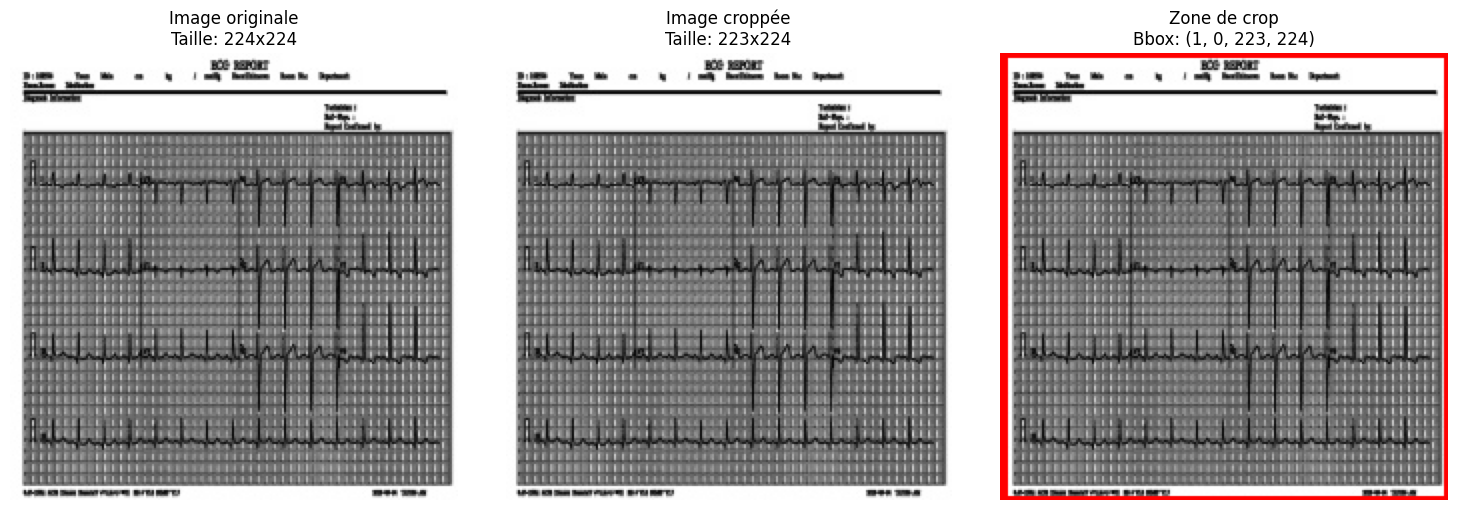


Résultats:
  Taille originale: 224x224
  Taille croppée: 223x224
  Réduction: 1px en largeur, 0px en hauteur
  Bounding box: x=1, y=0, w=223, h=224


In [ ]:
# ============================================================================
# TEST SUR UNE IMAGE
# ============================================================================

# Chemin vers une image de test
test_image_path = os.path.join(output_dir, "Anormal", "HB(1).jpg")

# Vérifier que l'image existe
if os.path.exists(test_image_path):
    print(f"Test sur l'image: {test_image_path}")
    
    # Charger l'image originale
    original = cv2.imread(test_image_path)
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    
    # Cropper les bordures blanches et supprimer le texte en haut
    cropped, bbox = crop_white_borders(test_image_path, threshold=250, padding=5, 
                                       remove_text_header=True, text_zone_height=0.25)
    
    if cropped is not None:
        cropped_rgb = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
        
        # Afficher les résultats
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(original_rgb)
        plt.title(f'Image originale\nTaille: {original.shape[1]}x{original.shape[0]}')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(cropped_rgb)
        plt.title(f'Image croppée\nTaille: {cropped.shape[1]}x{cropped.shape[0]}')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        # Afficher la zone croppée sur l'image originale
        img_with_bbox = original_rgb.copy()
        x, y, w, h = bbox
        cv2.rectangle(img_with_bbox, (x, y), (x+w, y+h), (255, 0, 0), 3)
        plt.imshow(img_with_bbox)
        plt.title(f'Zone de crop\nBbox: ({x}, {y}, {w}, {h})')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\nRésultats:")
        print(f"  Taille originale: {original.shape[1]}x{original.shape[0]}")
        print(f"  Taille croppée: {cropped.shape[1]}x{cropped.shape[0]}")
        print(f"  Réduction: {original.shape[1]-cropped.shape[1]}px en largeur, {original.shape[0]-cropped.shape[0]}px en hauteur")
        print(f"  Bounding box: x={bbox[0]}, y={bbox[1]}, w={bbox[2]}, h={bbox[3]}")
    else:
        print("Erreur lors du cropping")
else:
    print(f"L'image de test n'existe pas: {test_image_path}")
    print("Vérifiez le chemin ou exécutez d'abord les cellules précédentes pour créer les images.")


In [ ]:
# ============================================================================
# FONCTION POUR TRAITER TOUTES LES IMAGES DU DOSSIER
# ============================================================================

def process_all_images_crop(input_dir, output_dir, threshold=250, padding=5):
    """
    Croppe les bordures blanches de toutes les images d'un dossier
    et sauvegarde les résultats dans un nouveau dossier.
    
    Parameters:
    -----------
    input_dir : str
        Dossier contenant les images à traiter
    output_dir : str
        Dossier de destination pour les images croppées
    threshold : int
        Seuil pour détecter les bordures blanches (0-255)
    padding : int
        Padding à ajouter autour de l'image croppée (en pixels)
    """
    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)
    
    # Lister toutes les images
    image_extensions = ('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG')
    image_files = [f for f in os.listdir(input_dir) 
                   if f.lower().endswith(image_extensions)]
    
    if not image_files:
        print(f"Aucune image trouvée dans {input_dir}")
        return
    
    print(f"Traitement de {len(image_files)} images dans {input_dir}...")
    
    success_count = 0
    error_count = 0
    
    for idx, filename in enumerate(image_files, 1):
        input_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)
        
        try:
            # Cropper l'image
            cropped, bbox = crop_white_borders(input_path, threshold=threshold, padding=padding)
            
            if cropped is not None:
                # Sauvegarder l'image croppée
                cv2.imwrite(output_path, cropped)
                success_count += 1
                
                if idx % 50 == 0:
                    print(f"  Traité {idx}/{len(image_files)} images...")
            else:
                error_count += 1
                print(f"  Erreur sur {filename}")
                
        except Exception as e:
            error_count += 1
            print(f"  Erreur sur {filename}: {e}")
    
    print(f"\nTerminé!")
    print(f"  Images traitées avec succès: {success_count}")
    print(f"  Erreurs: {error_count}")
    print(f"  Images sauvegardées dans: {output_dir}")


In [ ]:
# ============================================================================
# APPLIQUER LE CROP À TOUTES LES IMAGES DU DOSSIER processed_dataset
# ============================================================================

# Dossiers source (images originales - à ne pas modifier)
processed_normal_dir = os.path.join(output_dir, "Normal")
processed_anormal_dir = os.path.join(output_dir, "Anormal")

# Dossiers de destination (images croppées)
# Créer un nouveau dossier au même niveau que processed_dataset
cropped_output_dir = os.path.join(os.path.dirname(output_dir), "processed_dataset_cropped")
cropped_normal_dir = os.path.join(cropped_output_dir, "Normal")
cropped_anormal_dir = os.path.join(cropped_output_dir, "Anormal")

# Paramètres de cropping
CROP_THRESHOLD = 250  # Seuil pour détecter le blanc (0-255)
CROP_PADDING = 5      # Padding en pixels autour de l'image croppée

print("=" * 70)
print("CROPPING DES BORDURES BLANCHES")
print("=" * 70)
print(f"Dossier source: {output_dir}")
print(f"Dossier destination: {cropped_output_dir}")
print(f"Seuil de blanc: {CROP_THRESHOLD}")
print(f"Padding: {CROP_PADDING} pixels")
print("=" * 70)
print()

# Traiter les images normales
if os.path.exists(processed_normal_dir):
    print("\n>>> Traitement des images NORMALES...")
    process_all_images_crop(processed_normal_dir, cropped_normal_dir, 
                           threshold=CROP_THRESHOLD, padding=CROP_PADDING)
else:
    print(f"\n>>> Dossier normal introuvable: {processed_normal_dir}")

# Traiter les images anormales
if os.path.exists(processed_anormal_dir):
    print("\n>>> Traitement des images ANORMALES...")
    process_all_images_crop(processed_anormal_dir, cropped_anormal_dir, 
                           threshold=CROP_THRESHOLD, padding=CROP_PADDING)
else:
    print(f"\n>>> Dossier anormal introuvable: {processed_anormal_dir}")

print("\n" + "=" * 70)
print("TRAITEMENT TERMINÉ")
print("=" * 70)
print(f"\nLes images originales dans '{output_dir}' n'ont pas été modifiées.")
print(f"Les images croppées ont été sauvegardées dans '{cropped_output_dir}'.")
